In [1]:
import pandas as pd
import numpy as np
import pickle
import gc
from pathlib import Path
import tensorflow as tf
import shap
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation, utils, localizer

2024-02-28 20:31:20.496746: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 20:31:20.496826: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 20:31:20.497627: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 20:31:20.504242: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-28 20:31:21.435858: W tensorflow/compiler/tf2

In [2]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1_v2/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

# challenge_data_dir = Path('submission/dataset/')
# data_dir = challenge_data_dir / "test"
# labels_dir = challenge_data_dir / 'test_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir, dtype=np.float32)

#some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:900]}

In [3]:
ds_gen = datahandler.DatasetGenerator(split_df=split_dataframes,
                                      non_transform_features=['Eccentricity',
                                                              'Semimajor Axis (m)',
                                                              'Inclination (deg)',
                                                              'RAAN (deg)',
                                                              'Argument of Periapsis (deg)',
                                                              #'True Anomaly (deg)',
                                                              #'Longitude (deg)',
                                                              'Latitude (deg)'],
                                      diff_transform_features=[#'Eccentricity',
                                                              #'Semimajor Axis (m)',
                                                              #'Inclination (deg)',
                                                              'RAAN (deg)',
                                                              'Argument of Periapsis (deg)',
                                                              'True Anomaly (deg)',
                                                              'Longitude (deg)',
                                                              'Latitude (deg)'
                                                              ],
                                      sin_transform_features=[#'Eccentricity',
                                                              #'Semimajor Axis (m)',
                                                              #'Inclination (deg)',
                                                              #'RAAN (deg)',
                                                              #'Argument of Periapsis (deg)',
                                                              #'True Anomaly (deg)',
                                                              #'Longitude (deg)',
                                                              #'Latitude (deg)'
                                                              ],
                                      sin_cos_transform_features=[],
                                      overview_features_mean=[#'Longitude (sin)',
                                                              #'RAAN (deg)'
                                                               ],
                                      overview_features_std=[#'Latitude (deg)'
                                                             ],
                                      add_daytime_feature=False,
                                      add_yeartime_feature=False,
                                      add_linear_timeindex=False,
                                      with_labels=True,
                                      nonbinary_padding=[110.0],
                                      train_val_split=0.8,
                                      input_stride=4,
                                      padding='none',
                                      input_history_steps=256,
                                      input_future_steps=256,
                                      per_object_scaling=False,
                                      scale=True,
                                      custom_scaler=None,
                                      unify_value_ranges=True,
                                      input_dtype=np.float32,
                                      sort_inputs=True,
                                      seed=181)

=========================Creating Generator=======================
Seed: 181
nTrain: 1520 nVal: 380 (0.80)
Padding: none
Horizons: 256-256 @ stride 4
Scaling: True  
Limiting True Anomaly to [0.0, 360.0] and Longitude to [-180.0, 180.0]
Diff Transforming features: ['RAAN (deg)', 'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Longitude (deg)', 'Latitude (deg)']
Padding node locations in non-binary fashion ([110.0])
Final 11 input features: ['Argument of Periapsis (deg)', 'Argument of Periapsis (deg) (diff)', 'Eccentricity', 'Inclination (deg)', 'Latitude (deg)', 'Latitude (deg) (diff)', 'Longitude (deg) (diff)', 'RAAN (deg)', 'RAAN (deg) (diff)', 'Semimajor Axis (m)', 'True Anomaly (deg) (diff)'] + overview of [] (mean) and [] (std)
=========================Finished Generator=======================


In [4]:
train_ds, val_ds = ds_gen.get_datasets(2048,
                                          label_features=['EW_Node_Location_nb', 'NS_Node_Location_nb'],
                                          shuffle=False,
                                          only_ew_sk=False,
                                          stride=1,
                                          keep_label_stride=500,
                                          verbose=1)
print(train_ds.element_spec) # 673786

  0%|          | 0/1520 [00:00<?, ?it/s]

100%|██████████| 1520/1520 [00:03<00:00, 444.59it/s]
2024-02-28 20:32:46.037229: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-28 20:32:46.057364: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-28 20:32:46.057451: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-28 20:32:46.059541: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-28 20:3

(TensorSpec(shape=(None, 128, 11), dtype=tf.float32, name=None), {'EW_Node_Location_nb': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'NS_Node_Location_nb': TensorSpec(shape=(None,), dtype=tf.float32, name=None)})


In [5]:
X_t = np.concatenate([element for element in train_ds.map(lambda x,y:x).as_numpy_iterator()])
y_t_ew = np.concatenate([element for element in train_ds.map(lambda x,y:y['EW_Node_Location_nb']).as_numpy_iterator()])

X_v = np.concatenate([element for element in val_ds.map(lambda x,y:x).as_numpy_iterator()])

In [6]:
import tensorflow.compat.v1.keras.backend as K
#tf.compat.v1.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()

In [7]:
model = tf.keras.models.load_model("submission/models/ID_localizer_cnn.hdf5", compile=False)

Instructions for updating:
Colocations handled automatically by placer.


2024-02-28 20:32:50.285083: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-28 20:32:50.285220: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-28 20:32:50.285292: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-28 20:32:50.285615: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-28 20:32:50.285629: I tensorflow/core/common_runtime/gpu/gpu

In [8]:
ew_model = tf.keras.Model(model.input, model.layers[-2].output)
ns_model = tf.keras.Model(model.input, model.layers[-1].output)
print(ew_model.summary())
print(ns_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 128, 11)]         0         
                                                                 
 conv1d (Conv1D)             (None, 122, 64)           4992      
                                                                 
 batch_normalization (Batch  (None, 122, 64)           256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 122, 64)           0         
                                                                 
 dropout (Dropout)           (None, 122, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 116, 64)           28736     
                                                             

Total params: 227121 (887.19 KB)
Trainable params: 226769 (885.82 KB)
Non-trainable params: 352 (1.38 KB)
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 128, 11)]         0         
                                                                 
 conv1d (Conv1D)             (None, 122, 64)           4992      
                                                                 
 batch_normalization (Batch  (None, 122, 64)           256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 122, 64)           0         
                                                                 
 dropout (Dropout)           (None, 122, 64)           0         
              

In [9]:
ew_explainer = shap.GradientExplainer(ew_model, X_t[200:1000])
shap_values_ew = ew_explainer.shap_values(X_v[1000:1400])
shap_values_ew = np.abs(shap_values_ew)
shap_values_ew = np.mean(shap_values_ew, axis=1)

ns_explainer = shap.GradientExplainer(ns_model, X_t[200:1000])
shap_values_ns = ns_explainer.shap_values(X_v[1000:1400])
shap_values_ns = np.abs(shap_values_ns)
shap_values_ns = np.mean(shap_values_ns, axis=1)

2024-02-28 20:32:51.634481: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


In [13]:
shap_values_ew.shape

(1, 128, 11)

In [11]:
df_ew = pd.DataFrame(shap_values_ew[0,:,:], columns=ds_gen._input_features)
df_ew['TIME'] = range(-256,256,4)

df_ns = pd.DataFrame(shap_values_ns[0,:,:], columns=ds_gen._input_features)
df_ns['TIME'] = range(-256,256,4)
df_ns.head(5)

ValueError: cannot reshape array of size 1408 into shape (80,11)

In [12]:
df_ew.plot.area(x='TIME',figsize=(10, 6), cmap='viridis')
plt.title("Deep SHAP - Feature Importance [EW]")
plt.show()

df_ns.plot.area(x='TIME',figsize=(10, 6), cmap='viridis')
plt.title("Deep SHAP - Feature Importance [NS]")
plt.show()

NameError: name 'df_ew' is not defined

Argument of Periapsis (deg)           12.379852
Argument of Periapsis (deg) (diff)     2.923424
Eccentricity                          50.990516
Inclination (deg)                     12.537496
Latitude (deg)                        13.439379
dtype: float64
Argument of Periapsis (deg)           0.315681
Argument of Periapsis (deg) (diff)    0.148079
Eccentricity                          1.000000
Inclination (deg)                     0.318475
Latitude (deg)                        0.334460
dtype: float64


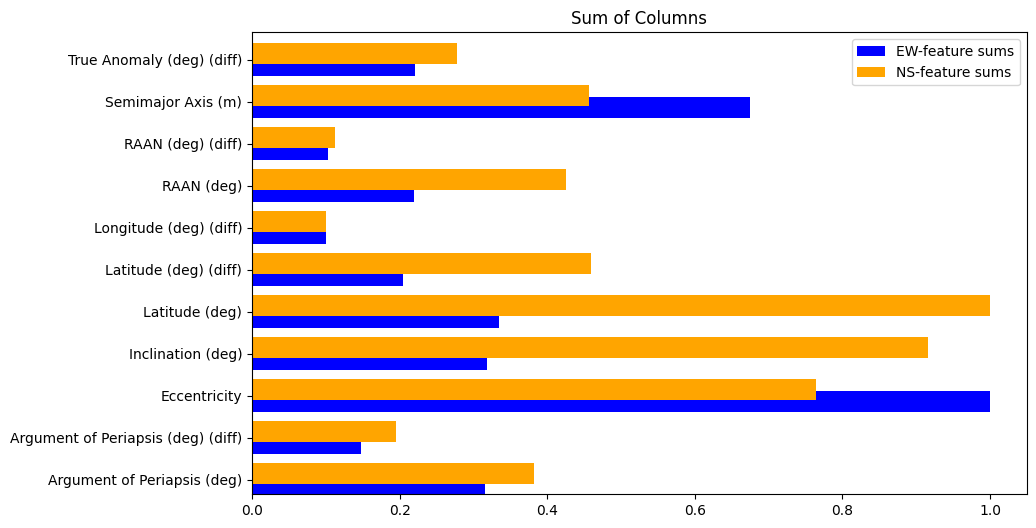

In [ ]:
# sum up values of columns for a feature importance overview
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler((0.1,1.0))
fig, ax  = plt.subplots(figsize=(10,6))
sum_of_columns_ew = df_ew[ds_gen._input_features].sum()
print(sum_of_columns_ew.head())
scaled_data_ew = scaler.fit_transform(sum_of_columns_ew.values.reshape(-1,1))
sum_of_columns_ew.update(pd.Series(scaled_data_ew[:,0], index=sum_of_columns_ew.index))
print(sum_of_columns_ew.head())
sum_of_columns_ew.plot(kind='barh', color='blue', ax=ax, position=0.8, label='EW-feature sums')

sum_of_columns_ns = df_ns[ds_gen._input_features].sum()
scaled_data_ns = scaler.fit_transform(sum_of_columns_ns.values.reshape(-1,1))
sum_of_columns_ns.update(pd.Series(scaled_data_ns[:,0], index=sum_of_columns_ns.index))
sum_of_columns_ns.plot(kind='barh', color='orange', ax=ax, position=0.2, label='NS-feature sums')

# Customize the plot
ax.set_title('Overall relative feature importance')
ax.legend()
plt.show()